In [181]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, ChainDataset
from torchvision.transforms import RandomHorizontalFlip, Compose
import numpy as np


# Loading the dataset

In [182]:
# from typing import Any
# class CustomConcatDataset(ConcatDataset):
#     def __len__(self):
#         # 여기에서 원하는 길이를 반환하도록 사용자 정의
#         # 예시로 첫 번째 데이터셋의 길이 반환
#         return len(self.datasets[0])*2


# class SubtractMean_and_HorizontalFlip():
#     def __init__(self, root, _dataset_name = "CIFAR100"):
#         super().__init__()
#         self.transform_flip = Compose([
#             ToTensor(),
#             RandomHorizontalFlip(p=1.0),
#         ])
        
#         # ger ref data
#         if _dataset_name == "CIFAR100":
#             self.ref_training_data = datasets.CIFAR100(
#                 root = root,
#                 train=True,
#                 download=True,
#                 transform=ToTensor(),
#             )
#             self.ref_test_data = datasets.CIFAR100(
#                 root = root,
#                 train=False,
#                 download=True,
#                 transform=ToTensor(),          
#             )
        
#         # make copy and apply transform(flip)
#         self.training_data1 = self.ref_training_data
#         self.training_data2 = self.ref_training_data
#         self.training_data2.transform = self.transform_flip
        
#         self.test_data1 = self.ref_test_data
#         self.test_data2 = self.ref_test_data
#         self.test_data2.transform = self.transform_flip
        
        
#         # subtract mean
#         mean = self.training_data1.data.mean(axis=(0, 1, 2))
#         self.training_data1.data = self.training_data1.data - mean
#         mean = self.training_data2.data.mean(axis=(0, 1, 2))
#         self.training_data2.data = self.training_data2.data - mean

#         mean = self.test_data1.data.mean(axis=(0, 1, 2))
#         self.test_data1.data = self.test_data1.data - mean
#         mean = self.test_data2.data.mean(axis=(0, 1, 2))
#         self.test_data2.data = self.test_data2.data - mean

#         # merge and 
#         self.training_data = CustomConcatDataset([self.training_data1, self.training_data2])
#         self.test_data = CustomConcatDataset([self.test_data1, self.test_data2])
#         self.training_data.__len__ = lambda: self.training_data1.__len__() + self.training_data2.__len__()
#         self.test_data.__len__ = lambda: self.test_data1.__len__() + self.test_data2.__len__()
#         return None
    
#     def unpack(self, *args: Any, **kwds: Any) -> Any:
#         pass
#         print("SubtractMean_and_HorizontalFlip")
#         return self.training_data, self.test_data
        

### flip까지 완료

In [183]:
# class SubtractMean_and_HorizontalFlip:
#     def __init__(self, root, _dataset_name="CIFAR100"):
#         self.transform_flip = Compose([
#             ToTensor(),
#             RandomHorizontalFlip(p=1.0),
#         ])
        
#         if _dataset_name == "CIFAR100":
#             self.ref_training_data = datasets.CIFAR100(
#                 root=root,
#                 train=True,
#                 download=True,
#                 transform=ToTensor(),
#             )
#             self.ref_test_data = datasets.CIFAR100(
#                 root=root,
#                 train=False,
#                 download=True,
#                 transform=ToTensor(),
#             )

#         # Make copies and apply transforms
#         self.training_data1 = self._apply_transform(self.ref_training_data)
#         self.training_data2 = self._apply_transform(self.ref_training_data, self.transform_flip)

#         self.test_data1 = self._apply_transform(self.ref_test_data)
#         self.test_data2 = self._apply_transform(self.ref_test_data, self.transform_flip)

#         # Merge datasets
#         self.training_data = ConcatDataset([self.training_data1, self.training_data2])
#         self.test_data = ConcatDataset([self.test_data1, self.test_data2])
        
#         # copy classes data
#         self.classes = self.ref_training_data.classes
#         self.training_data.classes = self.classes
#         self.test_data.classes = self.classes
        
#         self.class_to_idx = self.ref_training_data.class_to_idx
#         self.training_data.class_to_idx = self.class_to_idx
#         self.test_data.class_to_idx = self.class_to_idx
        
#     def _apply_transform(self, dataset, transform=None):
#         # when transform is None, return original dataset
#         # when transform is not None, return transformed dataset
#         # -> apply transform_flip
#         transformed_dataset = dataset
#         if transform is not None:
#             transformed_dataset = datasets.CIFAR100(
#                 root=dataset.root,
#                 train=dataset.train,
#                 download=True,  # Set this to False if you've already downloaded the data
#                 transform=transform,
#             )
#         """
#         # Subtract mean
#         하고싶은데, 이거 하면 unit8이 아니라서 dataloader에서 에러남
#         계산결과가 unit8이 아니고, float64로 변환됨.
#         """
#         # Subtract mean
#         # mean = np.mean(transformed_dataset.data, axis=(0, 1, 2))
#         # print(mean)
#         # transformed_dataset.data = transformed_dataset.data - mean
#         # print(np.mean(transformed_dataset.data, axis=(0, 1, 2)))
        
        
#         return transformed_dataset

#     def unpack(self):
#         print("SubtractMean_and_HorizontalFlip")
#         return self.training_data, self.test_data


# """
# subtract mean 적용 안된 것dd1
# """

### submean 시도

In [184]:
class Submean(torch.nn.Module):
    def __init__(self):
        super().__init__()

        return None
        """
        def __call__(self, tensor):
        def forward(self, tensor):
        둘 다 가능.
        근데, 처음에 한 번 적용되고 끝이 아니라
        데이터셋에 접근 할 때마다 계속 적용되는 것 같음.
        """

    def __call__(self, tensor):
        # Subtract the mean from each pixel along each channel
        print("input", tensor.shape)
        _mean = tensor.mean(axis=(1, 2))
        print("mean value before : ", _mean)
        tensor = tensor - _mean[:, None, None]
        print("mean value after : ", tensor.mean(axis=(1, 2)))

        return tensor


class SubtractMean_and_HorizontalFlip:
    def __init__(self, root, seceted_dataset="CIFAR100"):
        self.dataset_name = seceted_dataset
        self.transform_HorizontalFlip = Compose(
            [
                ToTensor(),
                RandomHorizontalFlip(p=1.0),
            ]
        )
        self.transform_default = Compose(
            [
                ToTensor(),
                Submean(),
            ]
        )
        if self.dataset_name == "CIFAR100":
            self.ref_training_data = datasets.CIFAR100(
                root=root,
                train=True,
                download=True,
                transform=self.transform_default,
            )
            self.ref_test_data = datasets.CIFAR100(
                root=root,
                train=False,
                download=True,
                transform=self.transform_default,
                #transform=ToTensor(),
            )
        elif self.dataset_name == "CIFAR10":
            self.ref_training_data = datasets.CIFAR10(
                root=root,
                train=True,
                download=True,
                transform=self.transform_default,
            )
            self.ref_test_data = datasets.CIFAR10(
                root=root,
                train=False,
                download=True,
                transform=self.transform_default,
                #transform=ToTensor(),
            )

        # Make copies
        self.training_data1 = self.ref_training_data
        self.training_data2 = self.ref_training_data

        # Apply Flip transform
        self.training_data2.transform = self.transform_HorizontalFlip
        print(
            "- Sucessfully return Train Set which applied SubtractMean_and_HorizontalFlip"
        )
        # Marge datasets
        self.training_data = ConcatDataset([self.training_data1, self.training_data2])

        # Copy classes data
        self.classes = self.ref_training_data.classes
        self.training_data.classes = self.classes

        self.class_to_idx = self.ref_training_data.class_to_idx
        self.training_data.class_to_idx = self.class_to_idx
        print("- Sucessfully return Test Set")
        return

    def unpack(self):
        print("-----------------------------------------------------------------------")
        print("Dataset : ", self.dataset_name)

        print("- Length of Train Set : ", len(self.training_data))
        print("- Length of Test Set : ", len(self.ref_test_data))
        # print(self.training_data.classes)
        print("- Count of Classes : ", len(self.training_data.classes))

        return self.training_data, self.ref_test_data, len(self.training_data.classes)

## Confirm that the dataset is loaded properly

In [185]:
BATCH = 256
DATASET = "CIFAR10"

In [186]:
_dataset = SubtractMean_and_HorizontalFlip(root="data", seceted_dataset=DATASET)
training_data, test_data, COUNT_OF_CLASSES = _dataset.unpack()

train_dataloader = DataLoader(training_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH, shuffle=True)

Files already downloaded and verified


Files already downloaded and verified
- Sucessfully return Train Set which applied SubtractMean_and_HorizontalFlip
- Sucessfully return Test Set
-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  100000
- Length of Test Set :  10000
- Count of Classes :  10


In [187]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print("mean of X", X.mean(dim=(0, 2, 3)))
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

input torch.Size([3, 32, 32])
mean value before :  tensor([0.5322, 0.5712, 0.4809])
mean value after :  tensor([-1.9791e-08,  1.0943e-08, -1.3388e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.6243, 0.4637, 0.3714])
mean value after :  tensor([ 1.0850e-07,  9.7789e-09, -2.0955e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3167, 0.3049, 0.3024])
mean value after :  tensor([-4.6566e-09,  2.4214e-08,  0.0000e+00])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.5865, 0.4013, 0.1995])
mean value after :  tensor([ 2.6543e-08,  1.0245e-08, -7.7998e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4080, 0.4336, 0.4255])
mean value after :  tensor([-3.4226e-08,  2.7474e-08, -2.5146e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3159, 0.2986, 0.2504])
mean value after :  tensor([-1.3970e-08, -1.3737e-08, -3.4925e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4029, 0.3237, 0.2621])
mean

input torch.Size([3, 32, 32])
mean value before :  tensor([0.5636, 0.5881, 0.6445])
mean value after :  tensor([-3.8883e-08,  2.4680e-08,  1.6997e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4488, 0.4445, 0.4734])
mean value after :  tensor([ 1.9558e-08, -1.6298e-08, -3.9581e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.6974, 0.6588, 0.6506])
mean value after :  tensor([-2.0140e-08, -2.8871e-08, -3.7486e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.8913, 0.8820, 0.9019])
mean value after :  tensor([ 3.1898e-08, -3.1665e-08,  2.9220e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4157, 0.4033, 0.3902])
mean value after :  tensor([-9.5461e-09, -3.3295e-08, -1.0710e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.6648, 0.5801, 0.5149])
mean value after :  tensor([ 4.2375e-08, -1.2107e-08,  1.8626e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3844, 0.4160, 0.3579])
mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([0.5988, 0.5204, 0.4262])
mean value after :  tensor([-1.7695e-08,  2.2817e-08, -1.2573e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3994, 0.4587, 0.5617])
mean value after :  tensor([-6.0536e-09, -9.3132e-09,  1.3970e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4382, 0.4390, 0.3569])
mean value after :  tensor([1.6298e-09, 1.5483e-08, 3.3760e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.6108, 0.6159, 0.6441])
mean value after :  tensor([ 2.9104e-08, -2.7008e-08, -4.4471e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.1853, 0.3793, 0.6712])
mean value after :  tensor([-2.5611e-08, -3.0384e-08, -2.6077e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4196, 0.4137, 0.4727])
mean value after :  tensor([ 2.0489e-08, -3.9581e-08, -1.7695e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4645, 0.4196, 0.3929])
mean value after :  tensor([-2.1188e-08,  2.1420e-08,  1.5

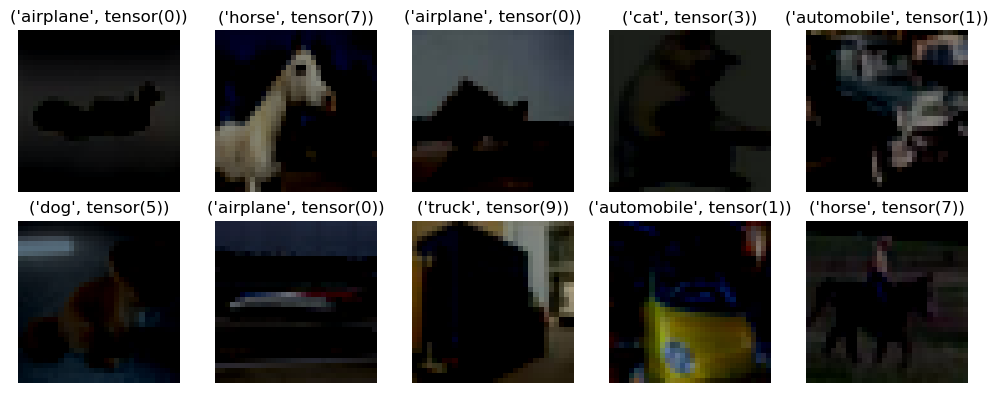

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class names
class_names = test_dataloader.dataset.classes
count = 0

# Create a subplot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the first batch of images and labels
for images, labels in test_dataloader:
    # Convert the images to numpy arrays
    images = images.numpy()
    
    # Iterate over the images and labels
    for i in range(len(images)):
        # Get the image and label
        image = images[i]
        label = labels[i]
        
        # Convert the image from tensor to numpy array
        image = np.transpose(image, (1, 2, 0))
        
        # Plot the image in the appropriate subplot
        ax = axs[count // 5, count % 5]
        ax.imshow(image)
        ax.set_title(f"{class_names[label], label}")
        ax.axis('off')
        
        # Increment the count
        count += 1
        
        # Break the loop if we have displayed 10 images
        if count == 10:
            break
            
    # Break the loop if we have displayed 10 images
    if count == 10:
        break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [189]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


# Imaplemant The Model

In [190]:
class Block(nn.Module):
    def __init__(self, inputs, outputs, _Downsample = False):
        super().__init__()
        self._Downsample = _Downsample

        
        self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        if self._Downsample == True:
            self.downsampling = nn.Sequential(
                # In paper, 
                # downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
                nn.Conv2d(inputs, outputs, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                # 이거 토치 공식 resnet에서도 배치까지 있는 4차원이라 conv2d로 함.
            )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m == self.conv1 and self._Downsample == True:
                    m.stride = (2, 2)
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # print('x1(identity) :', x.shape, 'Downsample :', self._Downsample)
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # print('x2 :', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self._Downsample == True:
            identity = self.downsampling(identity)
            # print('x1(downsampled) :', identity.shape)
        x = x + identity # 여기 x+=identity로 하면 안됨. inplace operation이라서.
        
        #x = self.relu2(x)
        # print('x3 :', x.shape)
        # print('x4 :', x.shape)
        return x
    
class MyResNet34(nn.Module):
    def __init__(self, _BlockClass = Block, _num_classes = 1000, _print = False):
        super().__init__()
        self._num_classes = _num_classes
        self._print = _print
        
        # 1. input layer
        # input : 224x224x3
        # output : 112x112x64
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # 2. 64ch 3x3 conv x 3
        # input : 112x112x64
        # output : 56x56x64
        self.conv64blocks = nn.Sequential(
            _BlockClass(64, 64),
            _BlockClass(64, 64),
            _BlockClass(64, 64)
        )
        # 3. 128ch 3x3 conv x 4
        # input : 56x56x64
        # output : 28x28x128
        self.conv128blocks = nn.Sequential(
            _BlockClass(64, 128, _Downsample = True),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
            _BlockClass(128, 128)
        )
        # 4. 256ch 3x3 conv x 6
        # input : 28x28x128
        # output : 14x14x256
        self.conv256blocks = nn.Sequential(
            _BlockClass(128, 256, _Downsample = True),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256)
        )
        # 5. 512ch 3x3 conv x 3
        # input : 14x14x256
        # output : 7x7x512
        self.conv512blocks = nn.Sequential(
            _BlockClass(256, 512, _Downsample = True),
            _BlockClass(512, 512),
            _BlockClass(512, 512)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features = 512, out_features= self._num_classes, bias=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        if(self._print): print('input 64ch :', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        if(self._print): print('conv7x7 64ch :', x.shape)
        x = self.maxpool(x)
        if(self._print): print('maxpool 64ch :', x.shape)
        
        x = self.conv64blocks(x)
        if(self._print): print('1st conv 64 :', x.shape)
        
        x = self.conv128blocks(x)
        if(self._print): print('2nd conv 128 :', x.shape)
        
        x = self.conv256blocks(x)
        if(self._print): print('3rd conv 256 :', x.shape)
        
        x = self.conv512blocks(x)
        if(self._print): print('4th conv 512:', x.shape)
        
        x = self.avgpool(x)
        if(self._print): print('avgpool :', x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = self.relu2(x)
        if(self._print): print('fc :', x.shape)
        
        return x

# Define the model

In [191]:
model = MyResNet34(Block, COUNT_OF_CLASSES, _print=False).to(device)
# model.named_modules

In [192]:
# How many have params?
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of total parameters: {total_params/1000/1000:2.2f}M")

Number of total parameters: 21.29M


In [193]:
# 모델 생성 및 손실 함수, 최적화기 정의
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop

In [194]:
num_epochs = 20

_log_train_loss = []
_log_train_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    #for inputs, labels in tqdm.tqdm(train_dataloader):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = correct / total

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    print("-" * 50)
    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)
    _log_test_loss.append(test_loss)
    _log_test_acc.append(test_acc)


input torch.Size([3, 32, 32])
mean value before :  tensor([0.6653, 0.5924, 0.5703])
mean value after :  tensor([-2.7241e-08,  1.2573e-08, -7.3109e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4383, 0.5247, 0.5796])
mean value after :  tensor([-1.1991e-08,  1.0303e-08, -5.5297e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3938, 0.3617, 0.3017])
mean value after :  tensor([ 1.4901e-08, -1.2340e-08,  2.2119e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3942, 0.4692, 0.2535])
mean value after :  tensor([-1.1176e-08, -8.4983e-09, -1.3970e-09])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4802, 0.4946, 0.4531])
mean value after :  tensor([-2.0955e-08, -8.6147e-09, -3.2363e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.4531, 0.4253, 0.4191])
mean value after :  tensor([ 1.3504e-08, -2.4214e-08,  1.5600e-08])
input torch.Size([3, 32, 32])
mean value before :  tensor([0.3244, 0.4474, 0.5466])
mean

KeyboardInterrupt: 

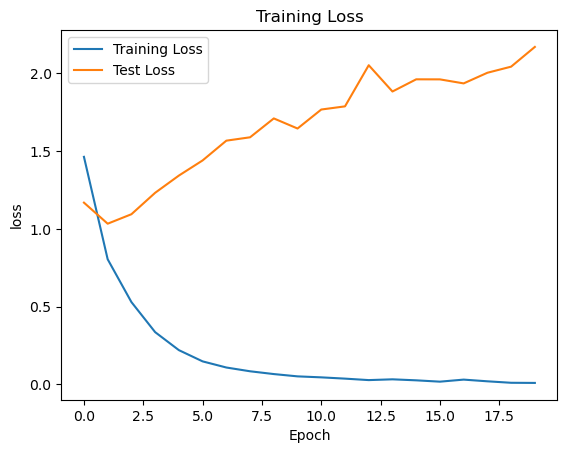

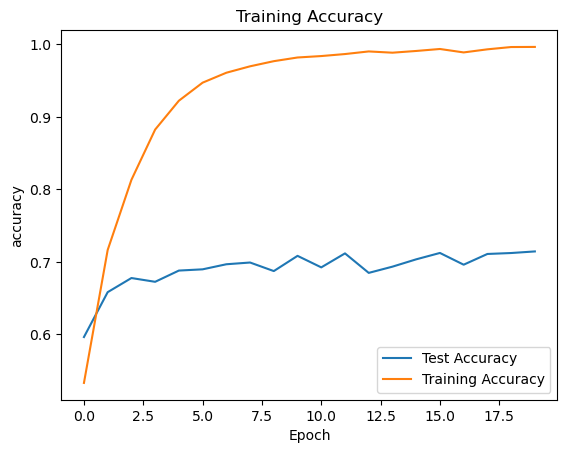

In [ ]:
# Plotting training loss and accuracy
plt.plot(_log_train_loss, label='Training Loss')
plt.plot(_log_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss')
plt.legend()
plt.show()


plt.plot(_log_test_acc, label='Test Accuracy')
plt.plot(_log_train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "models/Myresnet34.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = MyResNet34(Block, 100).to(device)
model.load_state_dict(torch.load("models/Myresnet34.pth"))

<All keys matched successfully>

In [ ]:
model.named_modules

<bound method Module.named_modules of MyResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv64blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU

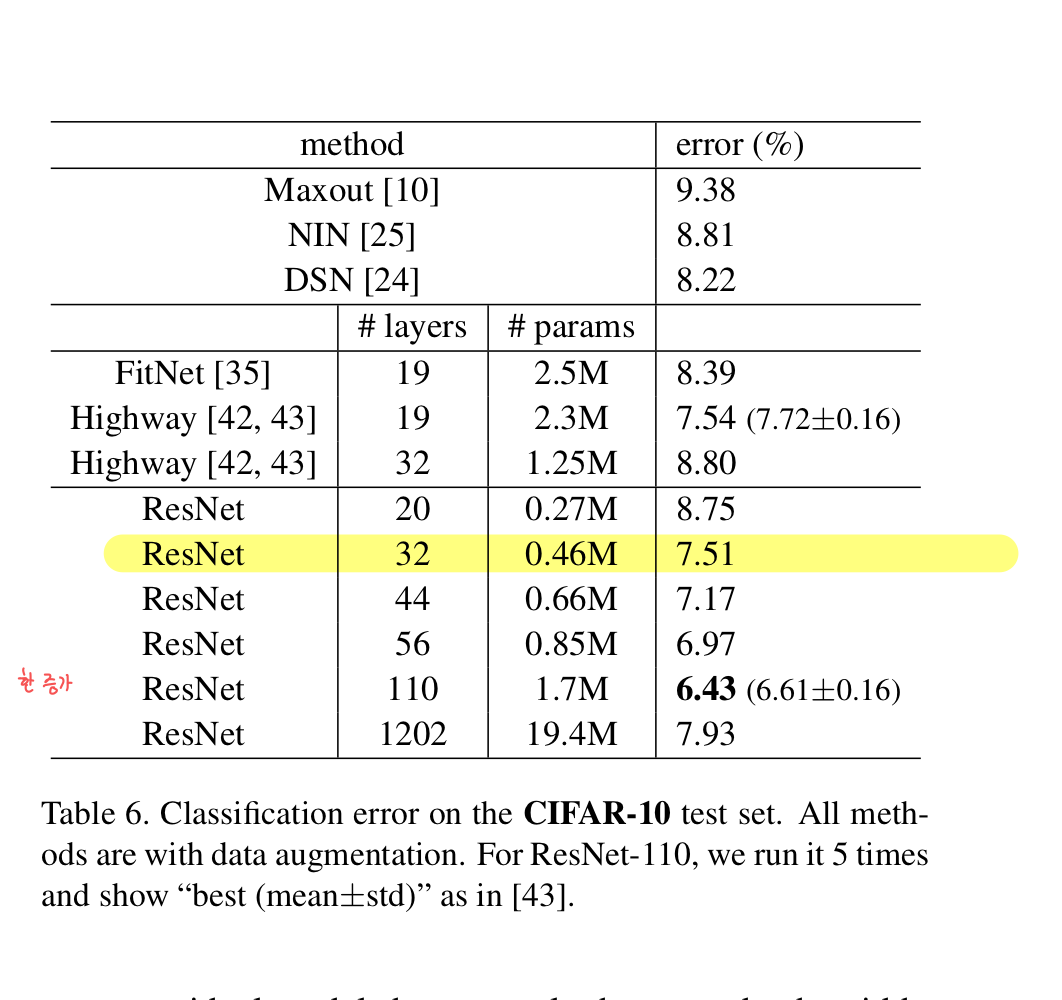